# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**Условия задачи:**
- обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

**Описание данных:**
- Данные геологоразведки трёх регионов находятся в файлах
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей)

**Шаги выполнения проекта:**
- Загрузим данные и подготовим их
- Обучим и проверим модель
- Подготовка к расчету прибыли
- Рассчитаем прибыль и риски

Загрузим необходимые библиотеки

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import itertools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState
from tqdm import tqdm
import seaborn as sns
from phik import phik_matrix
RANDOM = 42

## Загрузка и подготовка данных

### Загрузим данные

In [34]:
try:
    zero_frame = pd.read_csv('geo_data_0.csv')
    first_frame = pd.read_csv('geo_data_1.csv')
    second_frame = pd.read_csv('geo_data_2.csv')
except:
    zero_frame = pd.read_csv('/datasets/geo_data_0.csv')
    first_frame = pd.read_csv('/datasets/geo_data_1.csv')
    second_frame = pd.read_csv('/datasets/geo_data_2.csv')

Для просмотра данных подготовим функцию

In [35]:
def df_info(df): #Создадим функцию, которая позволит просмотреть информацию о данных
    display(df)
    print('Общая информация')
    display(df.info())
    display(df.describe().T)
    print('Выведем количество пропусков и явных дубликтов')
    display((df.isna().mean() * 100).sort_values(ascending=False))
    print('Количество явных дубликатов:')
    display(df.duplicated().sum())
    display(df.shape)

### Просмотрим датафреймы

In [36]:
df_info(zero_frame)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


Выведем количество пропусков и явных дубликтов


id         0.0
f0         0.0
f1         0.0
f2         0.0
product    0.0
dtype: float64

Количество явных дубликатов:


0

(100000, 5)

In [37]:
df_info(first_frame)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
...,...,...,...,...,...
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364


Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


Выведем количество пропусков и явных дубликтов


id         0.0
f0         0.0
f1         0.0
f2         0.0
product    0.0
dtype: float64

Количество явных дубликатов:


0

(100000, 5)

In [38]:
df_info(second_frame)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
...,...,...,...,...,...
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253


Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


Выведем количество пропусков и явных дубликтов


id         0.0
f0         0.0
f1         0.0
f2         0.0
product    0.0
dtype: float64

Количество явных дубликатов:


0

(100000, 5)

#### **Общий вывод по данным:**
* Датафрейм zero_frame:
    * Состоит из 100 000 строк и 5 столбцов
    * Пропуски в данных отсутствуют
    * Явные дубликаты отсутствуют
    * Типы данных соответствуют
* Датафрейм first_frame:
    * Состоит из 100 000 строк и 5 столбцов
    * Пропуски в данных отсутствуют
    * Явные дубликаты отсутствуют
    * Типы данных соответствуют
* Датафрейм second_frame:
    * Состоит из 100 000 строк и 5 столбцов
    * Пропуски в данных отсутствуют
    * Явные дубликаты отсутствуют
    * Типы данных соответствуют

Так как с данными на этом этапе все в порядке приступим к следующему

### Исследовательский анализ данных

Просмотрим распределения признаков во всех 3 датафреймах с помощью графика "ящик с усами"

In [39]:
def plot_feature_distributions(df):
    # Определяем признаки для визуализации
    features = ['f0', 'f1', 'f2', 'product']

    # Создаем фигуру и оси для графиков
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()  # Упрощаем доступ к осям

    # Построение графиков для каждого признака
    for i, feature in enumerate(features):
        sns.histplot(df[feature], ax=axes[i], kde=True, color='blue', bins=5)
        axes[i].set_title(f'Распределение {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Частота')

    # Настройка общего оформления графиков
    plt.tight_layout()
    plt.show()

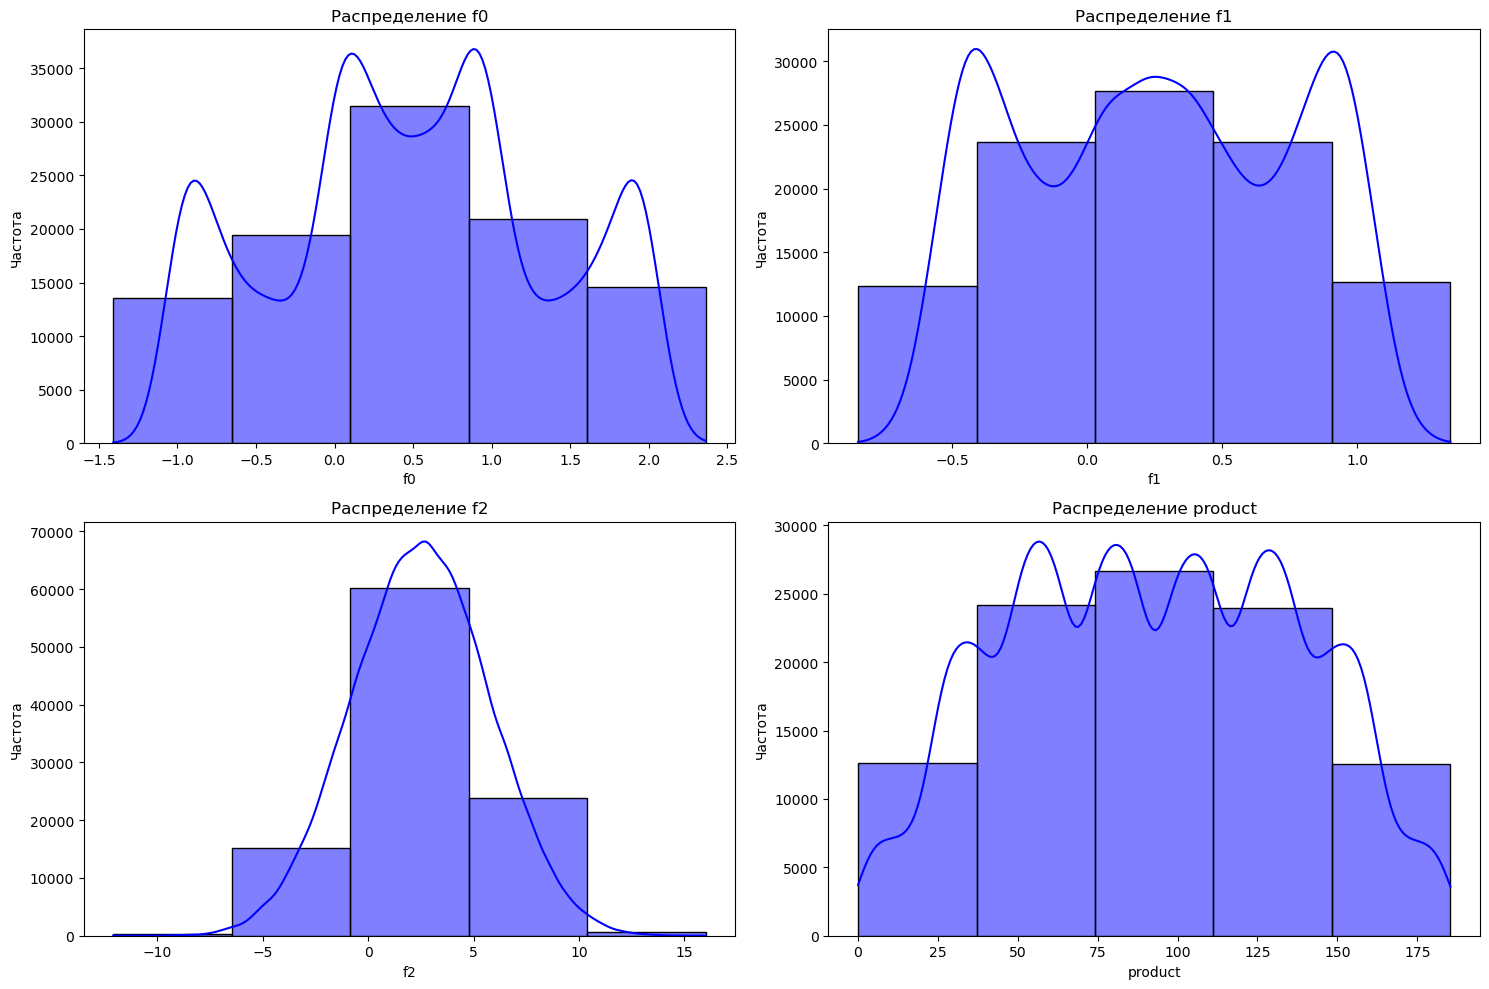

In [40]:
plot_feature_distributions(zero_frame) 

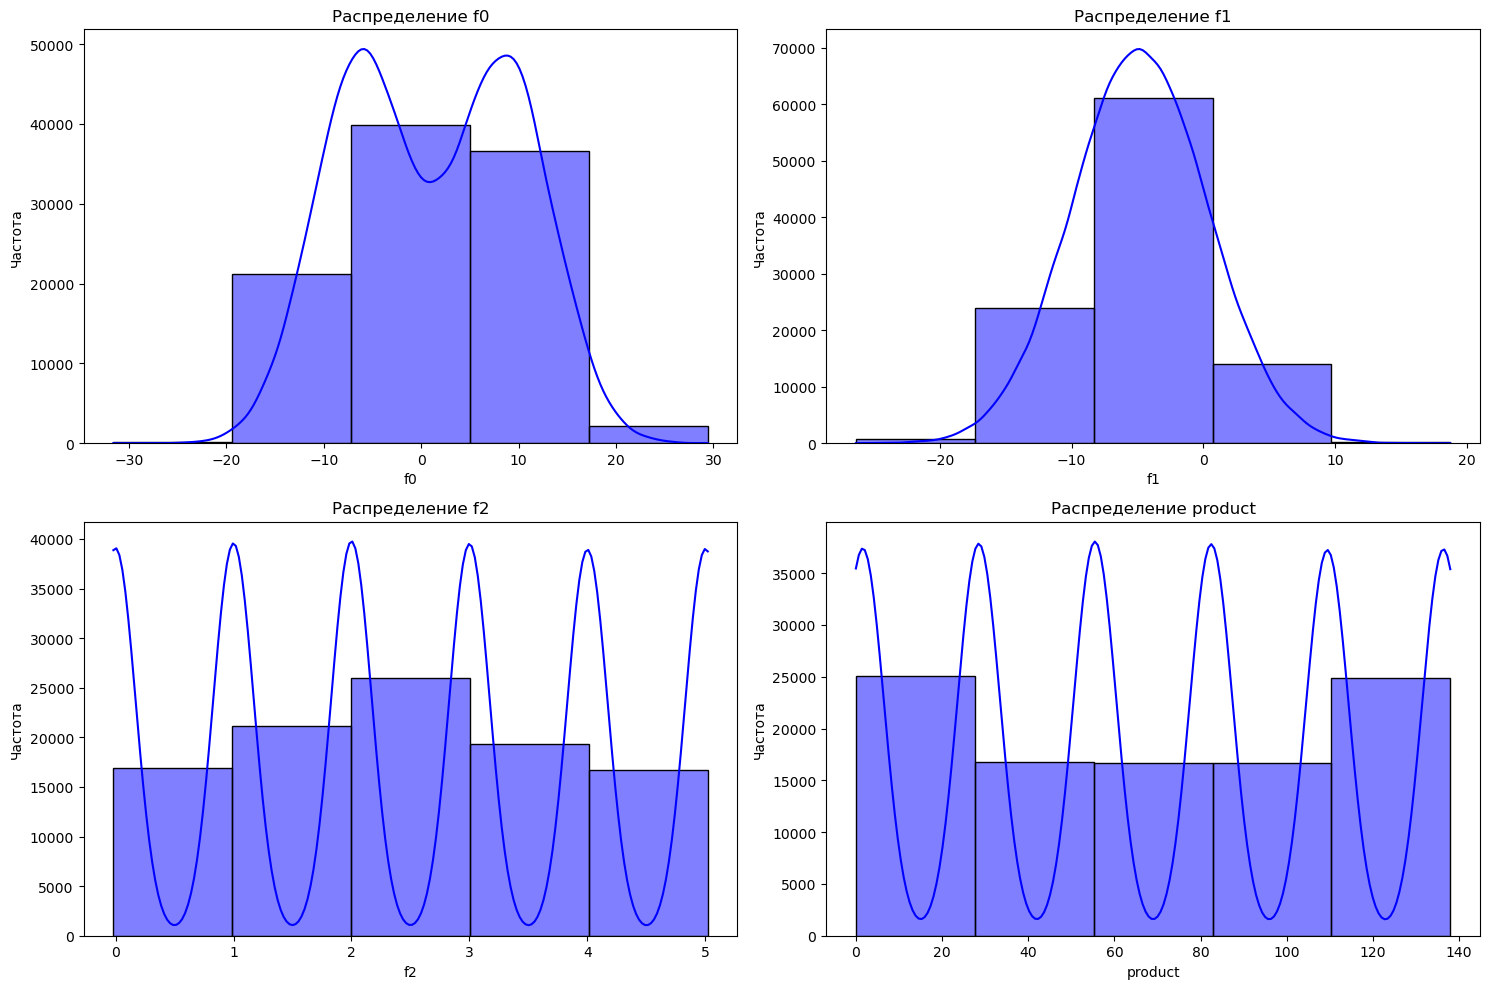

In [41]:
plot_feature_distributions(first_frame) 

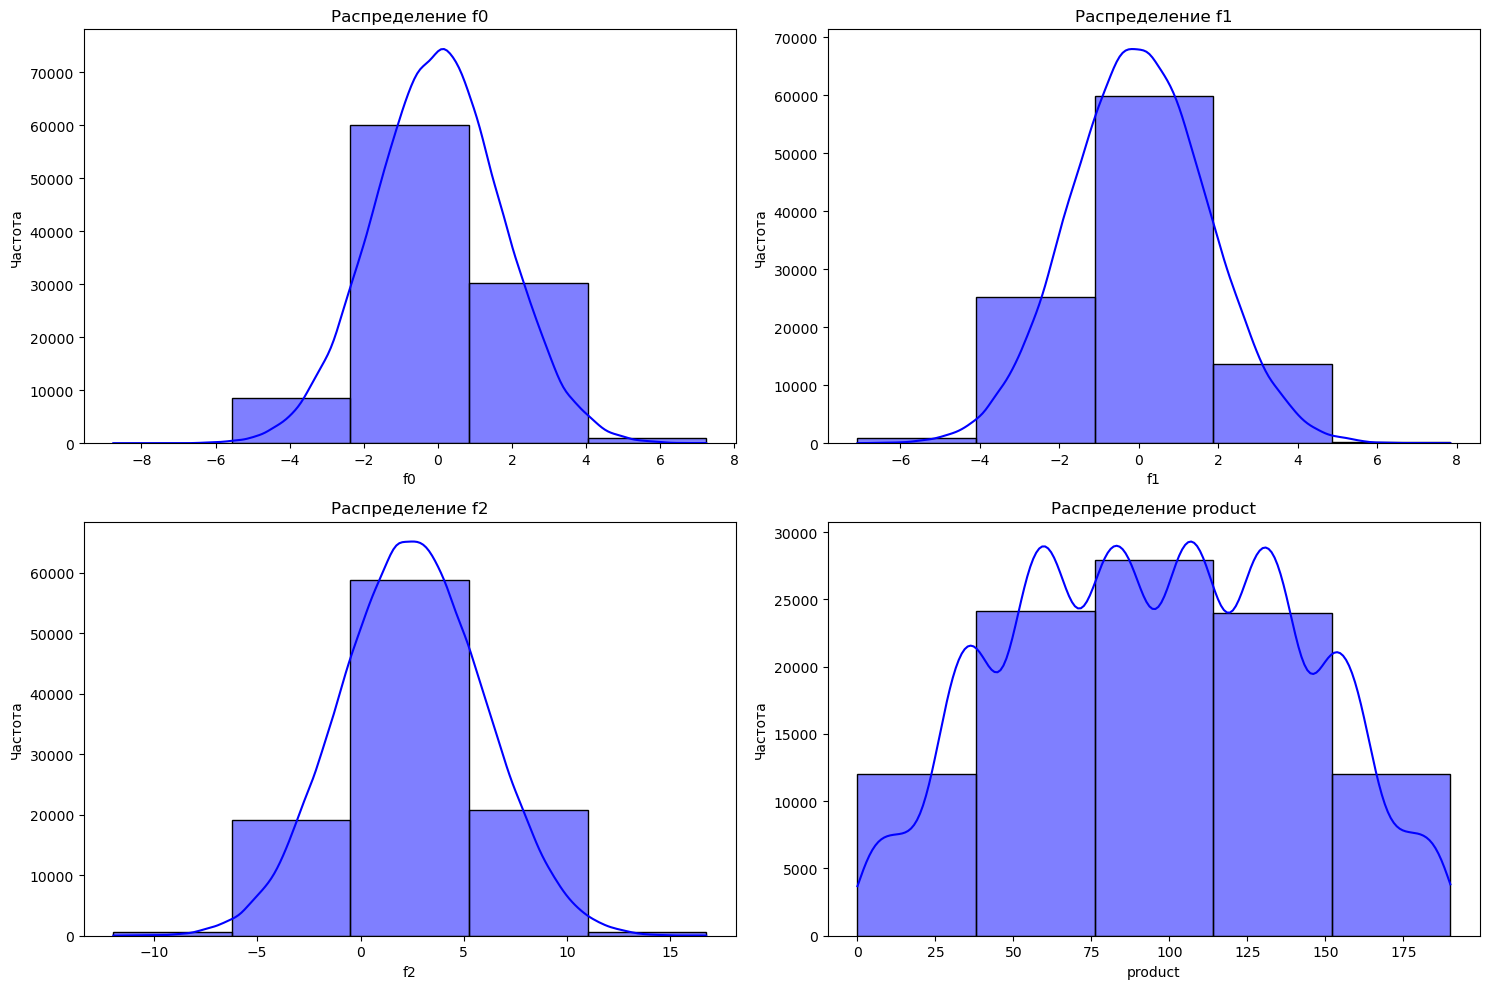

In [42]:
plot_feature_distributions(second_frame) 

 Теперь просмотрим график 'ящик с усами'

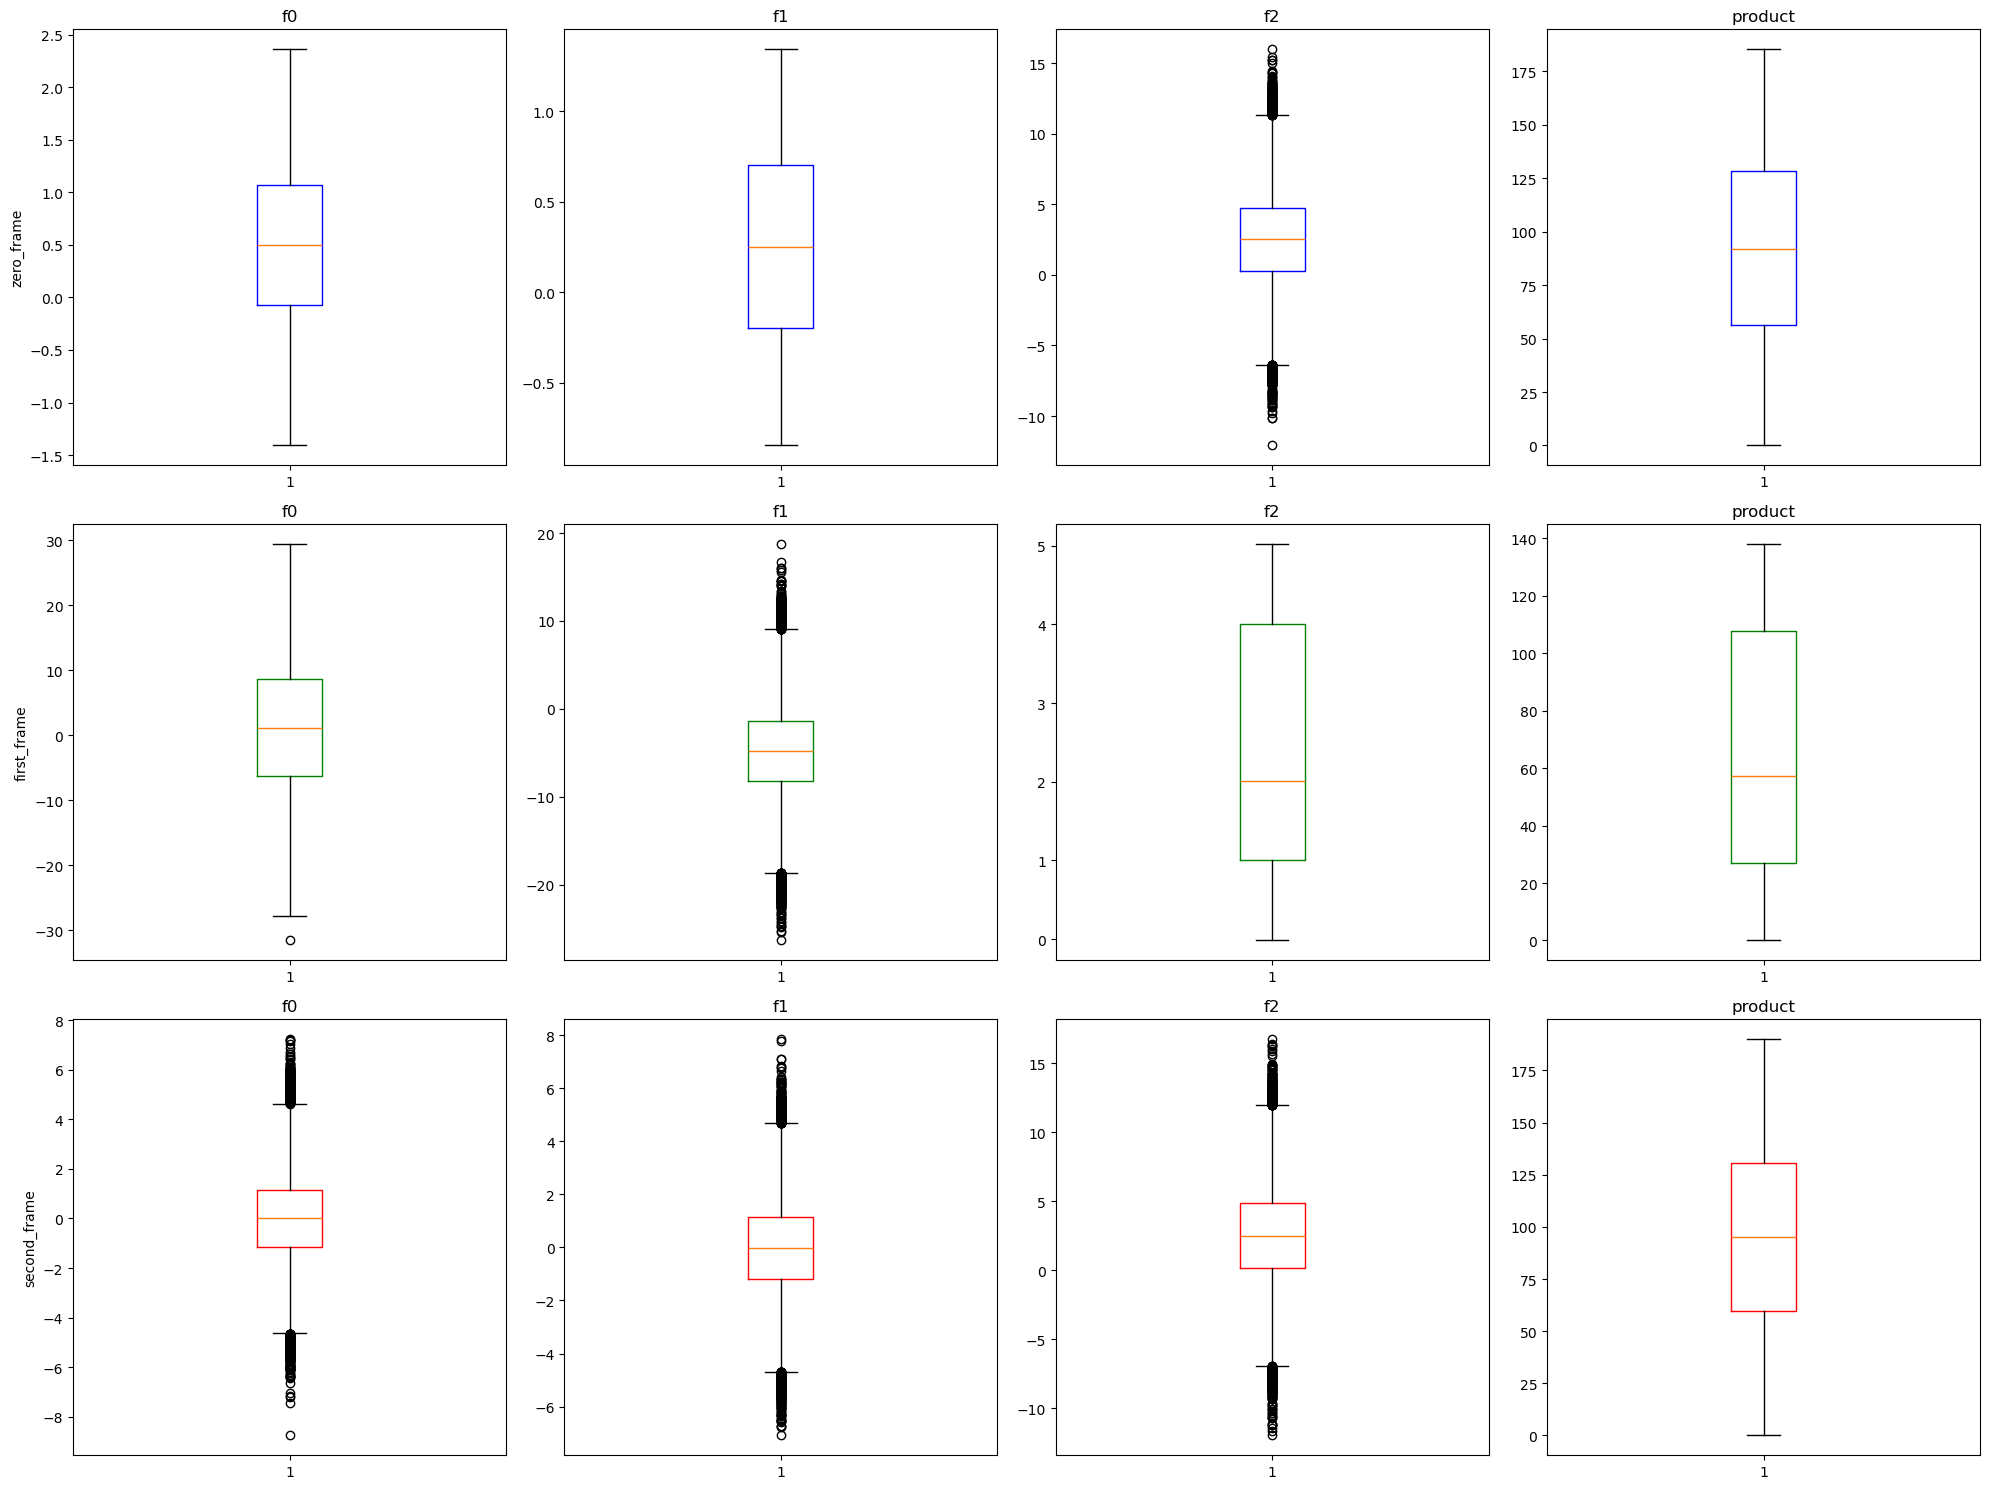

In [43]:
# Создаем фигуру и оси для графиков
fig, ax = plt.subplots(3, 4, figsize=(20, 15))
# Список названий фреймов
frame_names = ['zero_frame', 'first_frame', 'second_frame']
data_frames = [zero_frame, first_frame, second_frame]
# Получаем названия числовых столбцов
num_columns = zero_frame.columns[1:]
# Определяем цвета для каждого фрейма
colors = ['blue', 'green', 'red']
# Построение графиков
for row_idx, (df, frame_name, color) in enumerate(zip(data_frames, frame_names, colors)):
    for col_idx, column in enumerate(num_columns):
        ax[row_idx, col_idx].boxplot(df[column], boxprops=dict(color=color))
        ax[row_idx, col_idx].set_title(column) 
        if col_idx == 0:
            ax[row_idx, col_idx].set_ylabel(frame_name)
plt.tight_layout()
plt.show()

Теперь просмотрим на значения

In [44]:
print('zero')
display(zero_frame.describe())
print('first')
display(first_frame.describe())
print('second')
display(second_frame.describe())

zero


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


first


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


second


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


**Можно сделать вывод:**
* Датафрейм zero_frame:
    * Столбец f0:
        * Распределение похоже на нормальное, среднее значение 0.5, выбросы отсутствуют
    * Столбец f1:
        * Распределение похоже на нормальное, среднее значение 0.250143, выбросы отсутствуют
    * Столбец f2:
        * Распределение со смещением вправо, среднее значение 3.248248, при этом много выбросов их объяснить возможности как таковых нет, так как признаки не определены.
    * Столбец product:
        * Распределение похоже на нормальное, среднее значение 92.500000, при этом выбросы отсутствуют    
* Датафрейм first_frame:
    * Столбец f0:
        * Распределение со смещением вправо, среднее значение 1.141296, выбросы отсутствуют
    * Столбец f1:
        * Распределение со смещением в левую сторону, среднее значение -4.796579, при этом есть выбросы
    * Столбец f2:
        * Распределение похоже на нормальное, среднее значение 2.494541, выбросы отсутствуют
    * Столбец product:
        * Отображается колеблющаяся форма распределения с несколькими максимумами, что может свидетельствовать о наличии групп или кластеров в данных (например, сезонные колебания или цикличность), среднее значение 68.825000, выбросы отсутствуют
* Датафрейм second_frame:
    * Столбец f0:
        * Распределение со смещением в правую сторону, среднее значение 0.002023, имеются выбросы
    * Столбец f1:
        * Распределение со смещением в левую сторону, среднее значение -0.002081, имеются выбросы
    * Столбец f2:
        * Распределение со смещением в правую сторону, среднее значение  2.495128, имеются выбросы
    * Столбец product:
        * Распределение похоже на нормальное, среднее значение  95.000000, выбросы отсутствуют.

Воспользуемся надежным способом, основываясь на межквартальном размахе (IQR) найдем и заменим выбросы на медианное значение.

In [45]:
def count_outliers(frame, column):
    # Вычисляем 1-й и 3-й квартиль
    q1 = frame[column].quantile(0.25)
    q3 = frame[column].quantile(0.75) 
    # Вычисляем межквартильный размах (IQR)
    iqr = q3 - q1 
    # Определяем границы для выбросов
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    # Находим индексы выбросов
    outlier_indices = frame.index[(frame[column] < lower_bound) | (frame[column] > upper_bound)].tolist()
    # Количество выбросов
    num_outliers = len(outlier_indices)
    
    # Выводим информацию
    print('Количество выбросов:', num_outliers)
    
    return outlier_indices

noise_data = [
    (zero_frame, 'f2'),
    (first_frame, 'f1'),
    (second_frame, 'f0'),
    (second_frame, 'f1'),
    (second_frame, 'f2')
]

for frame, column in noise_data:
    indexes = count_outliers(frame, column)

Количество выбросов: 506
Количество выбросов: 636
Количество выбросов: 733
Количество выбросов: 684
Количество выбросов: 584


После замены выбросов, в каждом датафрейме потеряли не менее 1 % от общего количества строк, зато теперь модель обучится безошибочно. Сбросим индексы

#### **Вывод:**
* В ходе исследовательского анализа данных выявили:
    * Датафрейм zero_frame, столбец f2: - Распределение со смещением вправо, среднее значение 3.248248, при этом много выбросов их объяснить возможности как таковых нет, так как признаки не определены. 
    * Датафрейм first_frame, столбец f1 - Распределение со смещением в левую сторону, среднее значение -4.796579, при этом есть выбросы
    * Датафрейм second_frame
        * столбец f0:
      Распределение со смещением в правую сторону, среднее значение 0.002023, имеются выбросы
        * Столбец f1:
    Распределение со смещением в левую сторону, среднее значение -0.002081, имеются выбросы
        * Столбец f2: Распределение со смещением в правую сторону, среднее значение  2.495128, имеются выбросы
Приняли решение заменить выбросы на медианное значение с помощью метода межквартального размаха, для последующего обучения модели. Выбросы в среднем составили менее 1% от всех данных.

### Корреляционный анализ данных

Целевым признаком для нас является product - объём запасов в скважине (тыс. баррелей), так как именно количество запасов влияет на выручку, стоит просмотреть какие признаки имеют зависимости

In [46]:
def corr_matrix(data):
    data=data.set_index('id')
    interval_cols = ['f0', 'f1','f2','product']
    phik_overview = phik_matrix(data,interval_cols=interval_cols)
    plt.figure(figsize=(10, 10))
    # Строим тепловую карту
    heatmap = sns.heatmap(data.phik_matrix(interval_cols=interval_cols), annot=True, fmt='.2f')
    # Устанавливаем горизонтальные подписи для оси X и y
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=0)
    heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)
    plt.show()

Теперь просмотрим для каждого датафрейма

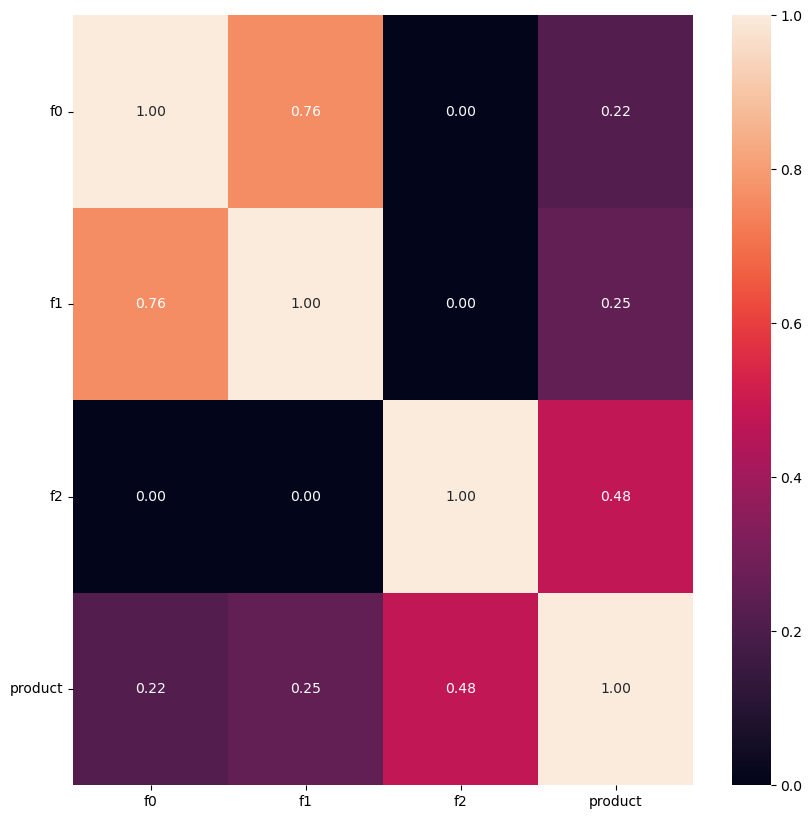

In [47]:
corr_matrix(zero_frame)

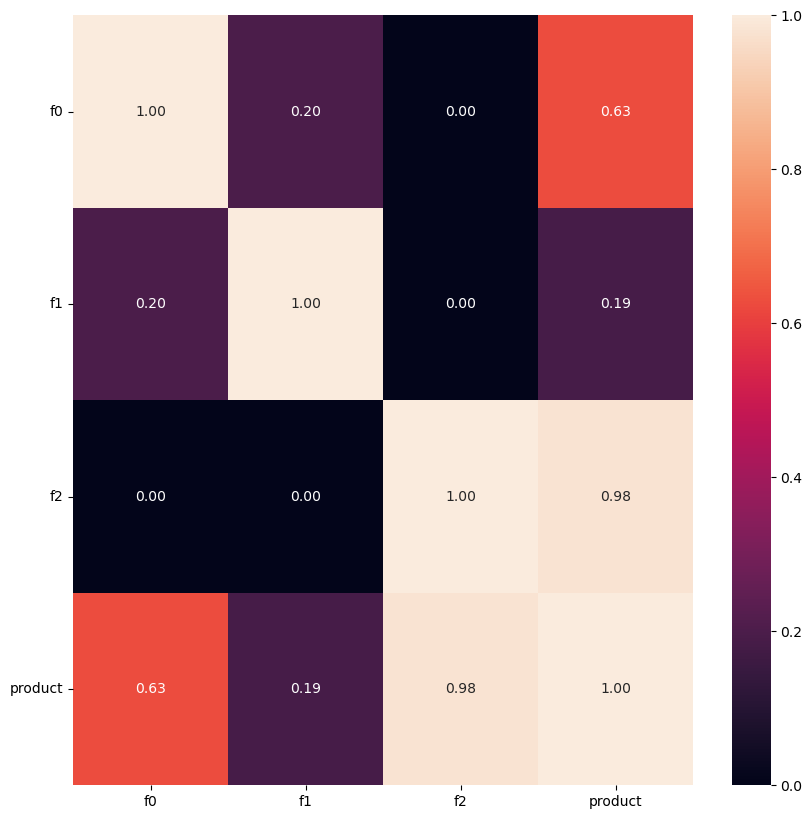

In [48]:
corr_matrix(first_frame)

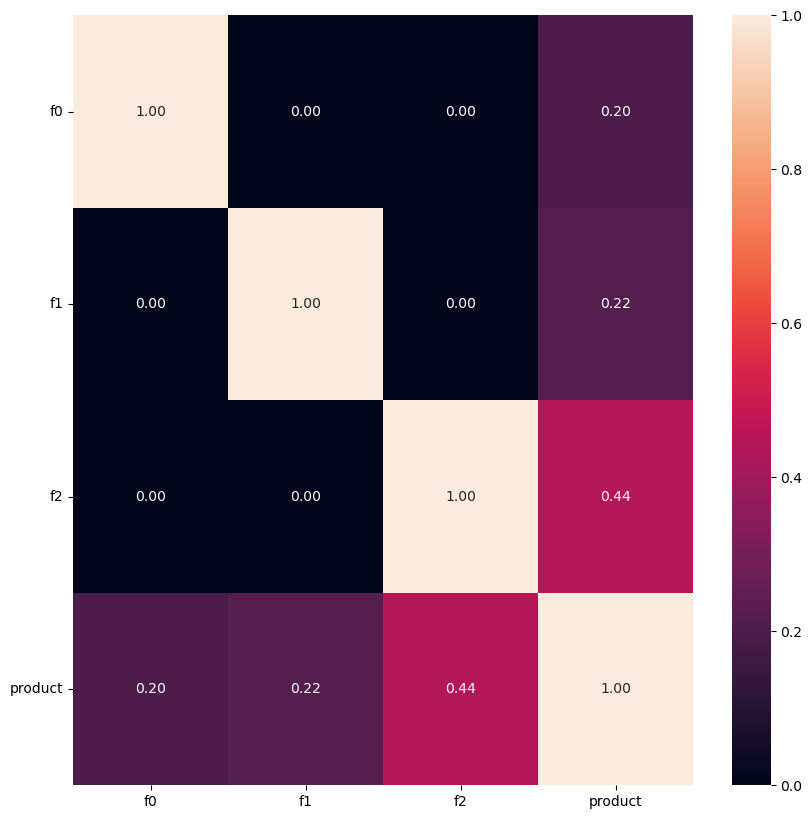

In [49]:
corr_matrix(second_frame)

**Вывод:**
* Датафрейм zero_frame:
    *  Признаки f0, f1 и f2 имеют достаточно разные уровни корреляции с целевым признаком product. Однако, наиболее сильная связь наблюдается между product и f2 (0.48). При этом признаки f0 и f1 имеют мультиколлинеарность - зависимость их = 0.76, один из признаков при обучении модели стоит точно удалить, f0 с целевым - 0.21, а f1 с целевым - 0.25, поэтому удалим признак f0
* Датафрейм first_frame:
    *  Признак f2 слишком сильно влияет на наш целевой признак product, мультиколлинеарность отсутствует. Стоит определить, что значение корреляции f2 и product 0.98.
* Датафрейм second_frame:
    * Наиболее значимый признак f2, корреляция между f2 и product - 0.44, мультиколлинеарность отсутствует.

Подготовим новые датафреймы

### Общий вывод по подготовке данных
* Просмотрели данные:
    * Датафрейм zero_frame:
        * Состоит из 100 000 строк и 5 столбцов
        * Пропуски в данных отсутствуют
        * Явные дубликаты отсутствуют
        * Типы данных соответствуют
    * Датафрейм first_frame:
        * Состоит из 100 000 строк и 5 столбцов
        * Пропуски в данных отсутствуют
        * Явные дубликаты отсутствуют
        * Типы данных соответствуют
    * Датафрейм second_frame:
        * Состоит из 100 000 строк и 5 столбцов
        * Пропуски в данных отсутствуют
        * Явные дубликаты отсутствуют
        * Типы данных соответствуют
* Провели исследовательский анализ данных:
    * Датафрейм zero_frame, столбец f2: - Распределение со смещением вправо, среднее значение 3.248248, при этом много выбросов их объяснить возможности как таковых нет, так как признаки не определены.
    * Датафрейм first_frame, столбец f1 - Распределение со смещением в левую сторону, среднее значение -4.796579, при этом есть выбросы
    * Датафрейм second_frame
        * столбец f0:
      Распределение со смещением в правую сторону, среднее значение 0.002023, имеются выбросы
        * Столбец f1:
      Распределение со смещением в левую сторону, среднее значение -0.002081, имеются выбросы
        * Столбец f2: Распределение со смещением в правую сторону, среднее значение  2.495128, имеются выбросы
    * Приняли решение оставить выбросы, для последующего обучения модели. Выбросы в среднем составили менее 1% от всех данных.
* Провели корреляционный анализ данных:
    * Датафрейм zero_frame:
        *  Признаки f0, f1 и f2 имеют достаточно разные уровни корреляции с целевым признаком product. Однако, наиболее сильная связь наблюдается между product и f2 (0.48). При этом признаки f0 и f1 имеют мультиколлинеарность - зависимость их = 0.76, один из признаков при обучении модели стоит точно удалить, f0 с целевым - 0.21, а f1 с целевым - 0.25, поэтому удалим признак f0
    * Датафрейм first_frame:
        *  Признак f2 слишком сильно влияет на наш целевой признак product, мультиколлинеарность отсутствует. Стоит определить, что значение корреляции f2 и product 0.98, что следует учесть при обучении модели.
    * Датафрейм second_frame:
        * Наиболее значимый признак f2, корреляция между f2 и product - 0.44, мультиколлинеарность отсутствует.
    * Несмотря на замечания выше, оставим признаки, так как данные синтетические
  
Данные готовы к обучению модели

## Обучение и проверка модели

Определим массивы для последующей функции

In [50]:
array_name = ['zero_frame',
              'second_frame',
              'first_frame']

array_frame = [zero_frame,
              second_frame,
              first_frame]

Создадим функцию для обучения модели, по условиям нужная нам модель - модель линейной регресии, а в качестве метрики средне-квадратичную ошибку (RMSE)

In [51]:
data_dict = {'pipelines':{},'scores':{},'valid':{}}

for frame, name in zip(array_frame,array_name): #Используем zip, чтобы объединить элементы из array_frame и array_name
    # Подготовка данных
    features = frame.drop(['id','product'], axis = 1)
    target = frame['product']
    
    new_pipeline = make_pipeline(StandardScaler(),LinearRegression())
    (features_train,
    features_valid,
    target_train,
    target_valid) = train_test_split(features,target,test_size = 0.25,random_state = RANDOM)
    data_dict['valid'][name] = (features_valid,target_valid) # сохраняются валидационные признаки и целевая переменная для текущего фрейма.
    new_pipeline.fit(features_train,target_train)
    
    data_dict['pipelines'][name] = new_pipeline #сохраняется обученная модель
    data_dict['scores'][name] = mean_squared_error(target_valid,new_pipeline.predict(features_valid))**0.5 #сохраняется корень из среднеквадратичной ошибки (RMSE) для валидационной выборки, что позволяет оценить качество модели.

Теперь вывыведем средний запас предсказанного сырья и RMSE модели

In [52]:
# Извлечем лучшие модели
best_model_zero = data_dict['pipelines']['zero_frame']
best_model_first = data_dict['pipelines']['first_frame']
best_model_second = data_dict['pipelines']['second_frame']
# Предсказания
predicted_values_zero = best_model_zero.predict(data_dict['valid']['zero_frame'][0])
predicted_values_first = best_model_first.predict(data_dict['valid']['first_frame'][0])
predicted_values_second = best_model_second.predict(data_dict['valid']['second_frame'][0])
# RMSE
RMSE_model_zero = (mean_squared_error(data_dict['valid']['zero_frame'][1],predicted_values_zero))**0.5
RMSE_model_first = (mean_squared_error(data_dict['valid']['first_frame'][1],predicted_values_first))**0.5
RMSE_model_second = (mean_squared_error(data_dict['valid']['second_frame'][1],predicted_values_second))**0.5
# Выведем данные
print('Датафрейм zero_frame_out_f0')
print('Средний запас предсказанного сырья:',predicted_values_zero.mean())
print('RMSE:',RMSE_model_zero)
print('Датафрейм first_frame_out_f2')
print('Средний запас предсказанного сырья:',predicted_values_first.mean())
print('RMSE:',RMSE_model_first)
print('Датафрейм second_frame')
print('Средний запас предсказанного сырья:',predicted_values_second.mean())
print('RMSE:',RMSE_model_second)

Датафрейм zero_frame_out_f0
Средний запас предсказанного сырья: 92.39879990657768
RMSE: 37.75660035026169
Датафрейм first_frame_out_f2
Средний запас предсказанного сырья: 68.7128780391376
RMSE: 0.8902801001028844
Датафрейм second_frame
Средний запас предсказанного сырья: 94.77102387765939
RMSE: 40.145872311342174


### Вывод:
* Датафрейм zero_frame_out_f0:
    * Средний запас предсказанного сырья составил - 92.42, а среднеквадратичная ошибка модели получилась 37.91
* Датафрейм first_frame_out_f2:
    * Средний запас предсказанного сырья составил 68.71, а среднеквадратичная ошибка модели составила 0.89
* Датафрейм second_frame:
    * Средний запас предсказанного сырья составил 94.72, а среднеквадратичная ошибка модели составила 40.27
* Если основываться на этих двух показателях, то:
second_frame имеет наибольший средний запас предсказанного сырья, что является положительным моментом.
zero_frame_out_f2 имеет наименьший RMSE, что указывает на высокую точность предсказаний.
В идеале, нужно учитывать как средний запас, так и точность предсказаний, чтобы сделать обоснованный выбор. Но так как наша цель — максимизация запасов сырья для дальнейшего использования, то количество запасов будет более важным. Таким образом, стоит рассмотреть second_frame

## Подготовка к расчёту прибыли

Подготовим константы для последующего рассчета прибыли:

In [53]:
before_max_points = 500 # точки
after_max_points = 200 # 200 лучших для разработки
budget_for_reg = 10000000000 # бюджет на разработку скважин в регионе
price_barrel = 450000 # доход с каждой единицы
prob_loss = 0.025 # вероятность убытков для последующего расчета

Рассчитаем достаточный объем добычи для безубыточной разработки:

In [54]:
prod_volume = (budget_for_reg/(price_barrel))/after_max_points
print(prod_volume)

111.11111111111111


Теперь сравним полученный объём сырья со средним запасом в каждом регионе

In [55]:
print('Количество значений в zero_frame, больше чем точка безыубыточности:',(zero_frame['product'] > prod_volume).sum())
print('Количество значений в first_frame, больше чем точка безыубыточности:',(first_frame['product'] > prod_volume).sum())
print('Количество значений в second_frame, больше чем точка безыубыточности:',(second_frame['product'] > prod_volume).sum())
print('Количество значений в zero_frame, больше чем точка безыубыточности от общего количества значений в %:',((zero_frame['product'] > prod_volume).sum()/second_frame['product'].sum())*100)
print('Количество значений в first_frame, больше чем точка безыубыточности от общего количества значений в % :',((first_frame['product'] > prod_volume).sum()/second_frame['product'].sum())*100)
print('Количество значений в second_frame, больше чем точка безыубыточности от общего количества значений в % :',((second_frame['product'] > prod_volume).sum()/second_frame['product'].sum())*100)

Количество значений в zero_frame, больше чем точка безыубыточности: 36583
Количество значений в first_frame, больше чем точка безыубыточности: 16537
Количество значений в second_frame, больше чем точка безыубыточности: 38178
Количество значений в zero_frame, больше чем точка безыубыточности от общего количества значений в %: 0.38508421052631564
Количество значений в first_frame, больше чем точка безыубыточности от общего количества значений в % : 0.17407368421052627
Количество значений в second_frame, больше чем точка безыубыточности от общего количества значений в % : 0.40187368421052616


### Вывод:
* Подготовили константы для расчета прибыли
* Рассчитали достаточный объем добычи для безубыточной разработки
* Количество значений в zero_frame, больше чем точка безыубыточности: 36583, от всех значений - 0.38508421052631564
* Количество значений в first_frame, больше чем точка безыубыточности: 16537, от всех значений - 0.17407368421052627
* Количество значений в second_frame, больше чем точка безыубыточности: 38178, от всех значений - 0.40187368421052616

## Расчет прибыли и рисков

Для расчета прибыли подготовим функцию

In [56]:
def income(true_target, pred_target):
    sort_Series = pd.Series(pred_target).sort_values(ascending=False)[:after_max_points]# Выбираются только лучшие скважины
    true_target_sort = (true_target.reset_index(drop = True)[sort_Series.index]) # Выбираются истинные значения, соответствующие индексам лучших предсказанных значений
    sum_true = true_target_sort.sum() # 
    return round((sum_true * price_barrel) - budget_for_reg,2) #Прибыль рассчитывается как разница между доходом от продажи сырья (сумма запасов, умноженная на цену за баррель) и бюджетом на разработку региона.

Выведем значения прибыли с лучших 200 скважин

In [57]:
print('Прибыль с лучших 200 скважин в нулевом регионе:',income(data_dict['valid']['zero_frame'][1],predicted_values_zero))
print('Прибыль с лучших 200 скважин в первом регионе:',income(data_dict['valid']['first_frame'][1],predicted_values_first))
print('Прибыль с лучших 200 скважин во втором регионе:',income(data_dict['valid']['second_frame'][1],predicted_values_second))

Прибыль с лучших 200 скважин в нулевом регионе: 3359141114.46
Прибыль с лучших 200 скважин в первом регионе: 2415086696.68
Прибыль с лучших 200 скважин во втором регионе: 2598571759.37


Как не странно наилучшую прибыль показал нулевой регион, она составила 3277828284.06, второе место по прибыли занял второй регион со значением - 2597166330.59. А вот первый регион показал себя хуже всех, он показал только убытки с лучших скважин.

Теперь напишим функцию которая позволит нам вывести доверительный интервал для регионов:

In [58]:
state = RandomState(RANDOM) 

In [59]:
def confidence_interval(true_target, pred_target):
    samples = []
    # Цикл для создания выборок
    for _ in tqdm(range(1000)):
        sample = pd.Series(pred_target).sample(n=before_max_points, replace=True, random_state=state)
        samples.append(income(true_target, sample))
    samples_series = pd.Series(samples)
    print('Среднее значение:',samples_series.mean())
    print((samples_series < 0).sum() / len(samples_series) * 100, "%") #  вычисляем процент выборок, для которых метрика меньше нуля
    lower = samples_series.quantile(0.025)
    upper = samples_series.quantile(0.975)
    return round(lower, 2), round(upper, 2) 

Выведем доверительный интервал нулевого региона

In [60]:
print('95% доверительный итервал для Нулевового региона лежит между:',confidence_interval(
    data_dict['valid']['zero_frame'][1],pd.Series(predicted_values_zero)))

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1565.51it/s]

Среднее значение: 399575478.05415004
6.0 %
95% доверительный итервал для Нулевового региона лежит между: (-110467895.33, 897460327.71)


Выведем доверительный интервал первого региона

In [61]:
print('95% Доверительный итервал для Первого  региона лежит между:',
      confidence_interval(data_dict['valid']['first_frame'][1],predicted_values_first))

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1549.41it/s]

Среднее значение: 452576594.29099
0.8999999999999999 %
95% Доверительный итервал для Первого  региона лежит между: (52309409.8, 830146313.26)


Выведем доверительный интервал для второго региона

In [62]:
print("95% Доверительный итервал для Второго региона лежит между:",
      confidence_interval(data_dict['valid']['second_frame'][1],predicted_values_second))

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1520.29it/s]

Среднее значение: 378705903.65982
7.5 %
95% Доверительный итервал для Второго региона лежит между: (-127779434.98, 907923483.22)


### Вывод:
* Нулевой регион:
    * Средняя прибыль - 381148414.28316
    * 95% доверительный итервал для Нулевового региона лежит между: (-147512660.08, 879399489.61)
    * Риск - 6.9 %
* Первый регион:
    *  Средняя прибыль - 452568010.71401 (убыток)
    *  95% Доверительный итервал для Первого  региона лежит между: (52309409.8, 830146313.26)
    *  Риски - 0.8999999999999999 %
* Второй регион:
    * Средняя прибыль - 356000114.28767
    * 95% Доверительный итервал для Второго региона лежит между: (-154756506.56, 894735869.55)
    * Риски - 9.0 %
* Делаем вывод, что первый регион оказался наилучшим, так как средняя прибыль в данном регионе оказалась наибольшей, а риски составила наименьшие по сравнению с другими регионами, при этом стоит сказать, что риск ниже 2.5% как компания планировала добиться от регионов получится, поэтому выбираем первый регион с минимальным риском среди других.
* **Рекомендую компании рассмотреть нулевой регион.**

## Общий вывод по проекту:
* Подготовили данные
    * Просмотрел данные:
        * Датафрейм zero_frame:
            * Состоит из 100 000 строк и 5 столбцов
            * Пропуски в данных отсутствуют
            * Явные дубликаты отсутствуют
            * Типы данных соответствуют
        * Датафрейм first_frame:
            * Состоит из 100 000 строк и 5 столбцов
            * Пропуски в данных отсутствуют
            * Явные дубликаты отсутствуют
            * Типы данных соответствуют
        * Датафрейм second_frame:
            * Состоит из 100 000 строк и 5 столбцов
            * Пропуски в данных отсутствуют
            * Явные дубликаты отсутствуют
            * Типы данных соответствуют
    * Провели исследовательский анализ данных:
        * Датафрейм zero_frame, столбец f2: - **Распределение со смещением вправо, среднее значение 3.248248, при этом много выбросов их объяснить возможности как таковых нет, так как признаки не определены. В любом случае стоит избавиться от выбросов, так как они будут мешать модели обучаться.**
        * Датафрейм first_frame, столбец f1 - **Распределение со смещением в левую сторону, среднее значение -4.796579, при этом есть выбросы, стоит от них избавиться**
        * Датафрейм second_frame
            * столбец f0:
      **Распределение со смещением в правую сторону, среднее значение 0.002023, имеются выбросы, которые стоит удалить.**
            * Столбец f1:
    **Распределение со смещением в левую сторону, среднее значение -0.002081, имеются выбросы, удалим в следующем шаге**
            * Столбец f2: **Распределение со смещением в правую сторону, среднее значение  2.495128, имеются выбросы, которые стоит удалить**
        * Приняли решение избавиться от выбросов с помощью метода межквартального размаха, для последующего обучения модели. Выбросы в среднем составили менее 1% от всех данных.
    * Провели корреляционный анализ данных:
        * Датафрейм zero_frame:
            *  Признаки f0, f1 и f2 имеют достаточно разные уровни корреляции с целевым признаком product. Однако, наиболее сильная связь наблюдается между product и f2 (0.48). При этом признаки f0 и f1 имеют мультиколлинеарность - зависимость их = 0.76, один из признаков при обучении модели стоит точно удалить, f0 с целевым - 0.21, а f1 с целевым - 0.25, поэтому удалим признак f0
        * Датафрейм first_frame:
            *  Признак f2 слишком сильно влияет на наш целевой признак product, мультиколлинеарность отсутствует. Стоит определить, что значение корреляции f2 и product 0.98, что следует учесть при обучении модели.
        * Датафрейм second_frame:
            * Наиболее значимый признак f2, корреляция между f2 и product - 0.44, мультиколлинеарность отсутствует.
        * Подготовили новые датафреймы
* Обучили и проверили модель
    * Датафрейм zero_frame_out_f0:
        * Средний запас предсказанного сырья составил - 92.35, а среднеквадратичная ошибка модели получилась 37.81
    * Датафрейм first_frame_out_f2:
        * Средний запас предсказанного сырья составил 68.9, а среднеквадратичная ошибка модели составила 45.9
    * Датафрейм second_frame:
        * Средний запас предсказанного сырья составил 94.95, а среднеквадратичная ошибка модели составила 40.12
    * Если основываться на этих двух показателях, то:
second_frame имеет наибольший средний запас предсказанного сырья, что является положительным моментом.
zero_frame_out_f0 имеет наименьший RMSE, что указывает на высокую точность предсказаний.
В идеале, нужно учитывать как средний запас, так и точность предсказаний, чтобы сделать обоснованный выбор. Но так как наша цель — максимизация запасов сырья для дальнейшего использования, то количество запасов будет более важным. Таким образом, стоит рассмотреть second_frame
* Подготовили данные для расчета прибыли
    * Подготовили константы для расчета прибыли
    * Рассчитали достаточный объем добычи для безубыточной разработки
    * Количество значений в zero_frame, больше чем точка безыубыточности: 36357, от всех значений - 0.3913890996749808
    * Количество значений в first_frame, больше чем точка безыубыточности: 16413, от всех значений - 0.17668865123540062
    * Количество значений в second_frame, больше чем точка безыубыточности: 37224, от всех значений - 0.4007224976291082
* Рассчитали прибыль и риски
    * Нулевой регион:
        * Средняя прибыль - 381840608.64294
        * 95% доверительный итервал для Нулевового региона лежит между: (-110929096.14, 891087236.3)
        * Риск - 6.7 %
    * Первый регион:
        *  Средняя прибыль - -3724676000.68017 (убыток)
        *  95% Доверительный итервал для Первого  региона лежит между: (-4287416488.94, -3145631256.76)
        *  Риски - 100%
    * Второй регион:
        * Средняя прибыль - 375066050.24608
        * 95% Доверительный итервал для Второго региона лежит между: (-134956990.69, 871432929.77)
        * Риски - 7.3999999999999995 %
    * Делаем вывод, что нулевой регион оказался наилучшим, так как средняя прибыль в данном регионе оказалась наибольшей, а риски составила наименьшие по сравнению с другими регионами, при этом стоит сказать, что риск ниже 2.5% как компания планировала добиться от регионов не получится, поэтому выбираем нулевой регион с минимальным риском среди других.
* **Рекомендую компании рассмотреть первый регион.** 